In [1]:
# permission for the json to act
! chmod 600 /content/kaggle.json

In [2]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d dqmonn/zalando-store-crawl

100% 2.24G/2.24G [00:17<00:00, 179MB/s]
100% 2.24G/2.24G [00:17<00:00, 139MB/s]


In [3]:
# Mengekstrak file dataset

import zipfile
zip_file = zipfile.ZipFile('/content/zalando-store-crawl.zip')
zip_file.extractall('/tmp/')

In [4]:
import cv2

In [7]:
img = cv2.imread("/tmp/zalando/longsleeve/1VJ22O059-Q11@7.jpg")

img.shape

(875, 606, 3)

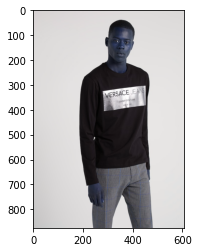

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [9]:
dir = "/tmp/zalando"

In [10]:
import tensorflow as tf

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,                                                                                                                   
                                                           rotation_range=0.2,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           zoom_range = 0.2, 
                                                           horizontal_flip=True,
                                                           validation_split = 0.02
                                                            )

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                           validation_split = 0.2
                                                           )

In [11]:
train_data = train_gen.flow_from_directory(dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           seed = 42,
                                           classes = ["hoodies","hoodies-female","longsleeve","shirt","sweatshirt","sweatshirt-female"],
                                           subset = "training"
                                           )

test_data = test_gen.flow_from_directory(dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["hoodies","hoodies-female","longsleeve","shirt","sweatshirt","sweatshirt-female"],
                                         seed = 42,
                                         subset = "validation"
                                         )

Found 15860 images belonging to 6 classes.
Found 3233 images belonging to 6 classes.


In [12]:
labels = list(train_data.class_indices.keys())

labels

['hoodies',
 'hoodies-female',
 'longsleeve',
 'shirt',
 'sweatshirt',
 'sweatshirt-female']

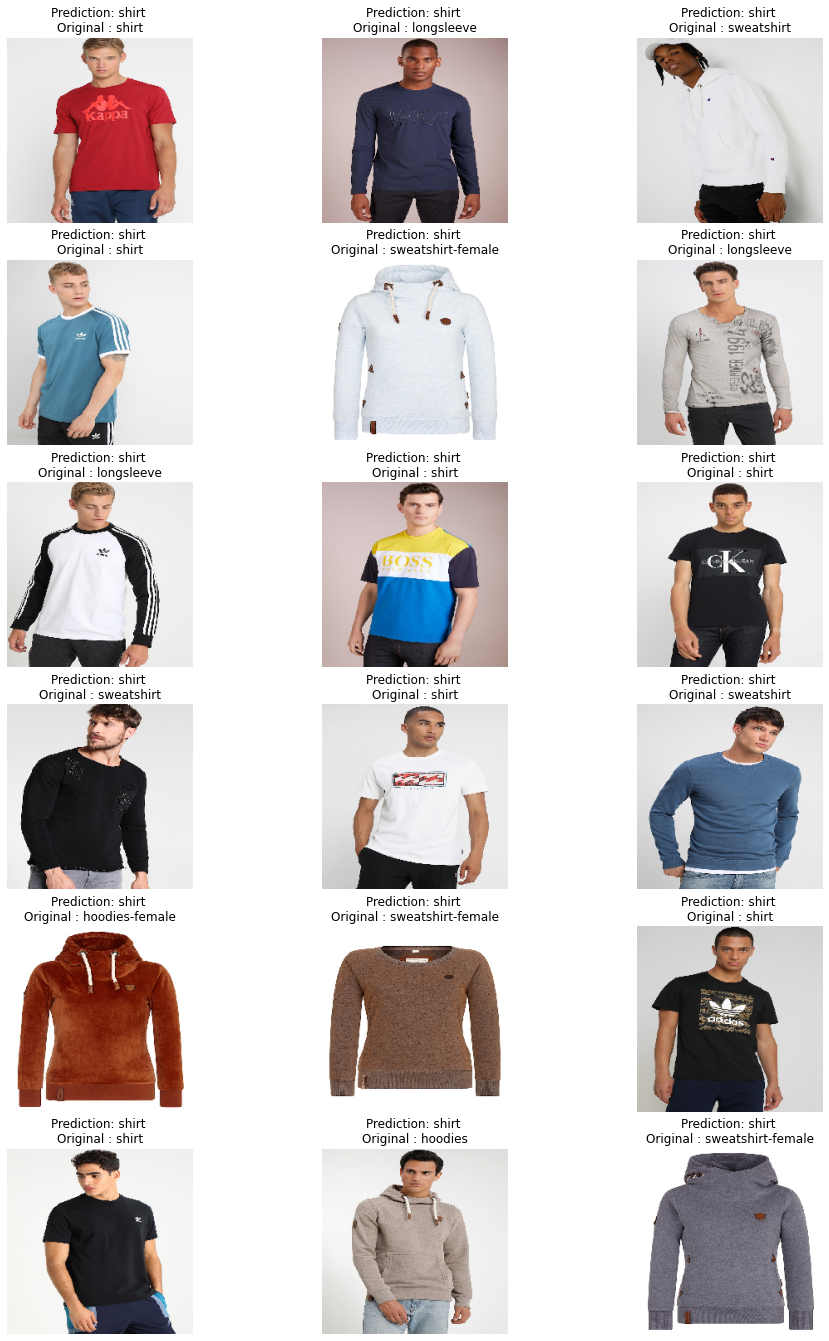

In [18]:
# visualizing the test data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):
  image, label = test_data.next()

  model_pred = model.predict(image)

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(f"Prediction: {labels[tf.argmax(model_pred[i])]} \nOriginal : {labels[tf.argmax(label[i])]}")
  plt.subplots_adjust(top= 1.25)
  plt.axis("off")

In [19]:
# building a ResNet model
import tensorflow as tf

base_model = tf.keras.applications.ResNet50V2(include_top= False) 

base_model.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [20]:
# building a resnet Model

import tensorflow as tf
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(6, activation="softmax")(x)

res_model = tf.keras.Model(inputs, outputs)

In [21]:
# compiling the model

res_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
    )

In [ ]:
# fitting data to the model

res_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
496/496 [==============================] - 2804s 6s/step - loss: 0.9441 - accuracy: 0.6125 - val_loss: 0.6828 - val_accuracy: 0.7043
Epoch 2/5
496/496 [==============================] - ETA: 0s - loss: 0.7902 - accuracy: 0.6537